Ending! No more underpressure available to drag the piston down 0.8831626629475587
29
4.831908850192757


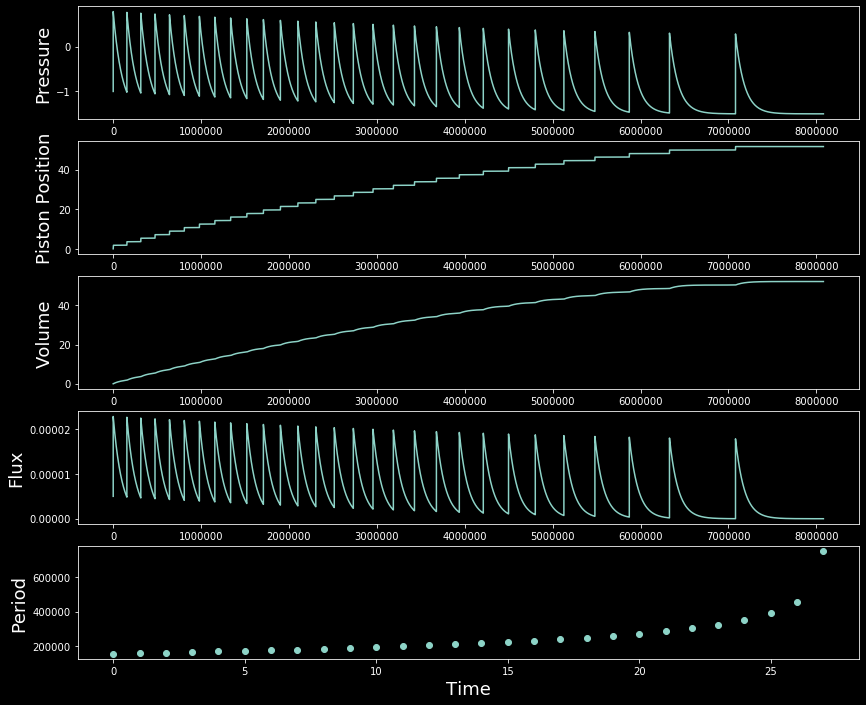

In [25]:
#### Here we calculate the first stick phase, ts is the moment at which the piston start to slip, at which Delta_P =  - R5
#R5 Fs/Fd for stick-slip you should have Fs/Fd> 1
#R3 PlS/Fd Contribution of the lithostatic to the outflow
# Having a time for stick implies R3 > R5 > 1
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
from scipy.integrate import odeint

mpl.style.use('dark_background')
R1 = 0.01
R2 = 1e-5
R3 = 1.5
R5 = 0.1
R4 = -R5

p = [R1,R2,R3,R5]

def slip_phase(w,time,p):
    R1,R2,R3,R5 = p
    deriv = [ w[1],
    -R1*w[0] - w[2] - R5,
    w[1] - R2*w[2] - R3*R2]
    return deriv
def stick_phase(p_stick,t_stick,x_stick,dt,R1,R2,R3,R4,R5):
    if t_stick == 0 :
        t_slip = -1/R2 * np.log((R3 - 1) / (R3 + R4))
        time = np.np.linspace(t_stick,t_slip,1000)
        Delta_P = (R3+ R4) * np.exp(-R2*time) - R3
        flag = 0
    elif (R3 - R1 * x_stick - 1) < 0:
        print('Ending! No more underpressure available to drag the piston down',R3 - R1 * x_stick - R5)  
        time = np.linspace(t_stick,t_stick + 1./R2*1e+1,1000)
        Delta_P = (p_stick + R3) * np.exp(R2*t_stick)*np.exp(-R2*time) -R3 
        flag = 1
    else:
        t_slip = -1 / R2*np.log((R3 - R1 * x_stick - 1)/((p_stick + R3)*np.exp(R2*t_stick)))
        time = np.linspace(t_stick,t_slip,1000)
        Delta_P = (p_stick + R3) * np.exp(R2*t_stick)*np.exp(-R2*time) -R3
        flag = 0
    return time, Delta_P,flag


def stick_phase_weight(p_stick,t_stick,x_stick,dt,R1,R2,R3,R4,R5):
    if t_stick == 0 :
        t_slip = -1/R2 * np.log((R3 - 1) / (R3 + R4))
        time = np.np.linspace(t_stick,t_slip,1000)
        Delta_P = (R3+ R4) * np.exp(-R2*time) - R3
        flag = 0
    elif (R3 - R1 * x_stick - 1) < 0:
        print('Ending! No more underpressure available to drag the piston down',R3 - R1 * x_stick - R5)  
        time = np.linspace(t_stick,t_stick + 1./R2*1e+1,1000)
        Delta_P = (p_stick + R3) * np.exp(R2*t_stick)*np.exp(-R2*time) -R3 
        flag = 1
    else:
        t_slip = -1 / R2*np.log((R3 - R1 * x_stick - 1)/((p_stick + R3)*np.exp(R2*t_stick)))
        time = np.linspace(t_stick,t_slip,1000)
        Delta_P = (p_stick + R3) * np.exp(R2*t_stick)*np.exp(-R2*time) -R3
        flag = 0
    return time, Delta_P,flag

t_start = 0
p_start = -1
x_start = 0.
v_start = 0
dt = 0.01
p = [R1,R2,R3,R5]
t_slip_start = []
dx_slip = []
tend =  5
t_slip_phase = np.linspace(0,tend,1000)
t_slip_start.append(0)
w0 = [x_start,v_start,p_start]
wsol = odeint(slip_phase, w0, t_slip_phase, args=(p,))
velocity = wsol[:,1]
v0 =velocity[velocity<0][0]
err_vel = np.abs(v0)
tend = t_slip_phase[velocity<0][0]
t_slip_phase = np.linspace(0,tend,1000)
wsol = odeint(slip_phase, w0, t_slip_phase, args=(p,))
x = wsol[:,0]
x_stick = x[-1]
v = wsol[:,1]
press = wsol[:,2]
t = t_slip_phase
dx_slip.append(wsol[-1,0]-wsol[0,0])

t_stick_phase, pres_stick,err_flag = stick_phase(press[-1],t[-1],x[-1],dt,R1,R2,R3,R4,R5)
press = np.concatenate((press,pres_stick))
x = np.concatenate((x,x_stick * np.ones(len(t_stick_phase))))
v = np.concatenate((v,np.zeros(len(t_stick_phase))))

t  = np.concatenate((t,t_stick_phase))
N_cycle = 1
while err_flag == 0 and N_cycle < 1000 :
    tend = t_stick_phase[-1] + 5
    t_slip_phase = np.linspace(t_stick_phase[-1],tend,1000)
    t_slip_start.append(t_slip_phase[0])
    w0 = [x[-1],v[-1],press[-1]]
    try:
        wsol = odeint(slip_phase, w0, t_slip_phase, args=(p,))
        velocity = wsol[:,1]
        v0 =velocity[velocity<0][0]
        err_vel = np.abs(v0)
        tend = t_slip_phase[velocity<0][0]
        t_slip_phase = np.linspace(t_stick_phase[-1],tend,1000)
        w0 = [x[-1],v[-1],press[-1]]
        wsol = odeint(slip_phase, w0, t_slip_phase, args=(p,))
        x = np.concatenate((x,wsol[:,0]))
        dx_slip.append(wsol[-1,0]-wsol[0,0])
        x_stick = x[-1]
        v = np.concatenate((v,wsol[:,1]))
        press = np.concatenate((press,wsol[:,2]))
        t = np.concatenate((t,t_slip_phase))
        t_stick_phase, pres_stick,err_flag = stick_phase(press[-1],t[-1],x[-1],dt,R1,R2,R3,R4,R5)
        press = np.concatenate((press,pres_stick))
        x = np.concatenate((x,x_stick * np.ones(len(t_stick_phase))))
        v = np.concatenate((v,np.zeros(len(t_stick_phase))))
        t  = np.concatenate((t,t_stick_phase))
        q = R2*R3 + R2 * press
        N_cycle = N_cycle + 1
    except ValueError:
        print('Error...')
        err_flag = 1
dt = np.diff(t)
V = np.zeros(len(t))
q = R2*R3 + R2 * press
Vc = 0
for i in range(len(dt)):
    dV = q[i]*dt[i]
    Vc = Vc + dV
    V[i+1]= Vc
t_slip = np.array(t_slip_start)
dx_slip = np.array(dx_slip)
tmin = np.min(t)
tmax = np.max(t)
periods = np.diff(t_slip)
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize = (14,12))
ax[0].plot(t,press)
ax[0].set_ylabel('Pressure',fontsize= 18)
ax[1].plot(t,x)
ax[1].set_ylabel('Piston Position',fontsize= 18)
ax[2].plot(t,V)
ax[2].set_ylabel('Volume',fontsize= 18)
ax[3].plot(t,q)
ax[3].set_ylabel('Flux',fontsize= 18)
ax[4].plot(periods,'o')
ax[4].set_ylabel('Period',fontsize= 18)
ax[4].set_xlabel('Time [Days]')
#ax[4].set_xlim([tmin,tmax])
ax[4].set_xlabel('Time',fontsize= 18)
print(N_cycle)
print(periods[-1]/periods[0])
plt.show()

In [26]:
taus = 1e+6
taud = taus * R5
taut = taus* R3
phi = (taus - taud) / (taut - taus)
2 * phi

3.6

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:234: RuntimeWarning: invalid value encountered in greater_equal
  if not((dt >= 0).all() or (dt <= 0).all()):
/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:234: RuntimeWarning: invalid value encountered in less_equal
  if not((dt >= 0).all() or (dt <= 0).all()):


Error...
9


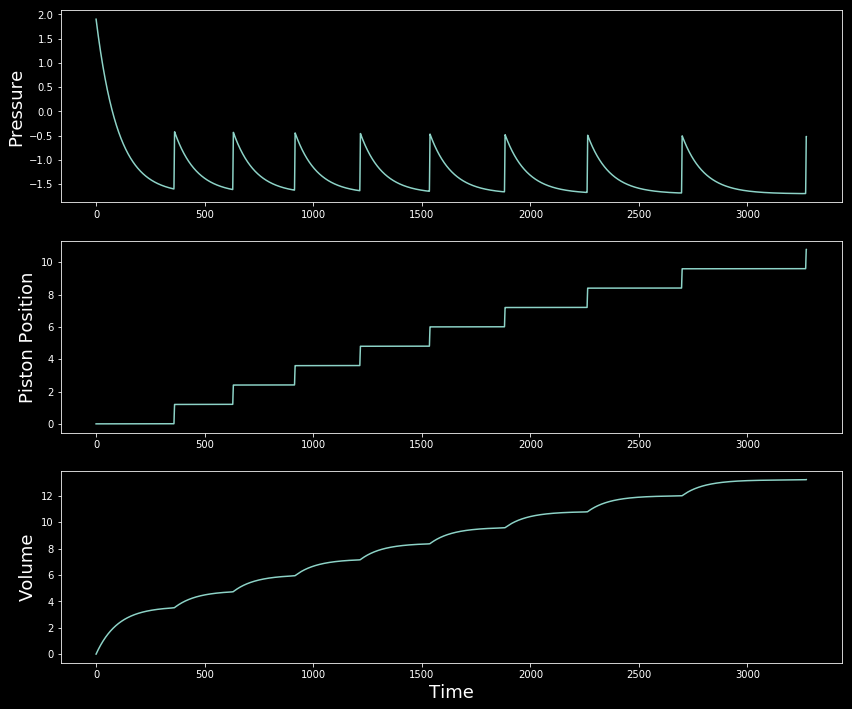

In [48]:
#Here we calculate the first stick phase, ts is the moment at which the piston start to slip, at which Delta_P =  - R5
#R5 Fs/Fd for stick-slip you should have Fs/Fd> 1
#R3 PlS/Fd Contribution of the lithostatic to the outflow
# Having a time for stick implies R3 > R5 > 1
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
mpl.style.use('dark_background')
R1 = 0.01
R2 = 1e-2
R3 = 1.7
R4 = 1.9
R5 = 1.6
p = [R1,R2,R3]
ts = -1/R2 * np.log((R3 - R5) / (R3 + R4))
t = np.linspace(0,ts,1000)
DeltaP = (R3+ R4) * np.exp(-R2*t) - R3

from scipy.integrate import odeint

def slip_phase(w,time,p):
    R1,R2,R3 = p
    deriv = [ w[1],
    -R1*w[0] - w[2] - 1,
    w[1] - R2*w[2] - R3*R2]
    return deriv
def stick_phase(p_stick,t_stick,x_stick,R1,R2,R3,R4,R5):
    if t_stick == 0 :
        t_slip = -1/R2 * np.log((R3 - R5) / (R3 + R4))
        time = np.linspace(t_stick,t_slip,1000)
        Delta_P = (R3+ R4) * np.exp(-R2*time) - R3
    else:
        t_slip = -1 / R2*np.log((R3 - R1 * x_stick - R5)/((p_stick + R3)*np.exp(R2*t_stick)))
        time = np.linspace(t_stick,t_slip,1000)
        Delta_P = (p_stick + R3) * np.exp(R2*t_stick)*np.exp(-R2*time) -R3 
    return time, Delta_P
t_start = 0
p_start = 0
x_start = 0
v_start = 0
t_stick_phase, pres_stick = stick_phase(p_start,t_start,x_start,R1,R2,R3,R4,R5)
x = np.zeros(len(pres_stick))
v = np.zeros(len(pres_stick))
t = t_stick_phase
press = pres_stick[:]
err_flag = 0
N_cycle = 0
while err_flag == 0 and N_cycle < 1e+3 :
    tend = t_stick_phase[-1] + 5
    t_slip_phase = np.linspace(t_stick_phase[-1],tend,1000)
    w0 = [x[-1],v[-1],press[-1]]
    try:
        wsol = odeint(slip_phase, w0, t_slip_phase, args=(p,))
        velocity = wsol[:,1]
        v0 =velocity[velocity<0][0]
        err_vel = np.abs(v0)
        tend = t_slip_phase[velocity<0][0]
        t_slip_phase = np.linspace(t_stick_phase[-1],tend,1000)
        w0 = [x[-1],v[-1],press[-1]]
        wsol = odeint(slip_phase, w0, t_slip_phase, args=(p,))
        x = np.concatenate((x,wsol[:,0]))
        x_stick = x[-1]
        v = np.concatenate((v,wsol[:,1]))
        press = np.concatenate((press,wsol[:,2]))
        t = np.concatenate((t,t_slip_phase))
        t_stick_phase, pres_stick = stick_phase(press[-1],t[-1],x[-1],R1,R2,R3,R4,R5)
        press = np.concatenate((press,pres_stick))
        x = np.concatenate((x,x_stick * np.ones(len(t_stick_phase))))
        v = np.concatenate((v,np.zeros(len(t_stick_phase))))
        t  = np.concatenate((t,t_stick_phase))
        N_cycle = N_cycle + 1
    except ValueError:
        print('Error...')
        err_flag = 1
dt = np.diff(t)
V = np.zeros(len(t))
q = R2*R3 + R2 * press
Vc = 0
for i in range(len(dt)):
    dV = q[i]*dt[i]
    Vc = Vc + dV
    V[i+1]= Vc
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (14,12))
ax[0].plot(t,press)
ax[0].set_ylabel('Pressure',fontsize= 18)
ax[1].plot(t,x)
ax[1].set_ylabel('Piston Position',fontsize= 18)
ax[2].plot(t,V)
ax[2].set_ylabel('Volume',fontsize= 18)
ax[2].set_xlabel('Time',fontsize= 18)
print(N_cycle)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:234: RuntimeWarning: invalid value encountered in greater_equal
  if not((dt >= 0).all() or (dt <= 0).all()):
/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:234: RuntimeWarning: invalid value encountered in less_equal
  if not((dt >= 0).all() or (dt <= 0).all()):


Error...
93


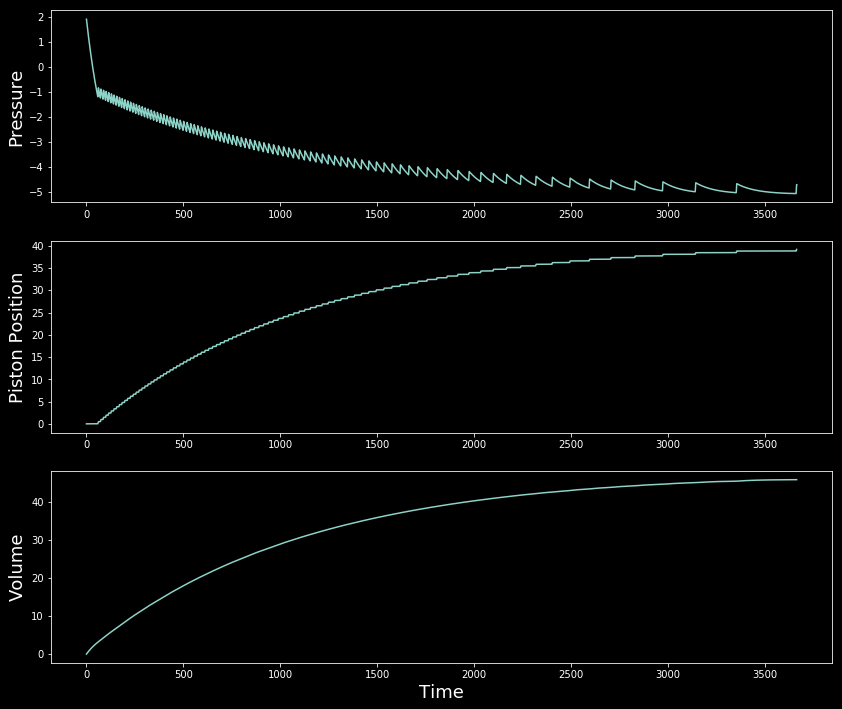

In [83]:
#Here we calculate the first stick phase, ts is the moment at which the piston start to slip, at which Delta_P =  - R5
#R5 Fs/Fd for stick-slip you should have Fs/Fd> 1
#R3 PlS/Fd Contribution of the lithostatic to the outflow
# Having a time for stick implies R3 > R5 > 1
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
mpl.style.use('dark_background')
R1 = 0.1
R2 = 1e-2
R3 = 5.1
R4 = 1.9
R5 = 1.2
p = [R1,R2,R3]
ts = -1/R2 * np.log((R3 - R5) / (R3 + R4))
t = np.linspace(0,ts,1000)
DeltaP = (R3+ R4) * np.exp(-R2*t) - R3

from scipy.integrate import odeint

def slip_phase(w,time,p):
    R1,R2,R3 = p
    deriv = [ w[1],
    -R1*w[0] - w[2] - 1,
    w[1] - R2*w[2] - R3*R2]
    return deriv
def stick_phase(p_stick,t_stick,x_stick,R1,R2,R3,R4,R5):
    if t_stick == 0 :
        t_slip = -1/R2 * np.log((R3 - R5) / (R3 + R4))
        time = np.linspace(t_stick,t_slip,1000)
        Delta_P = (R3+ R4) * np.exp(-R2*time) - R3
    else:
        t_slip = -1 / R2*np.log((R3 - R1 * x_stick - R5)/((p_stick + R3)*np.exp(R2*t_stick)))
        time = np.linspace(t_stick,t_slip,1000)
        Delta_P = (p_stick + R3) * np.exp(R2*t_stick)*np.exp(-R2*time) -R3 
    return time, Delta_P
t_start = 0
p_start = 0
x_start = 0
v_start = 0
t_stick_phase, pres_stick = stick_phase(p_start,t_start,x_start,R1,R2,R3,R4,R5)
x = np.zeros(len(pres_stick))
v = np.zeros(len(pres_stick))
t = t_stick_phase
press = pres_stick[:]
err_flag = 0
N_cycle = 0
while err_flag == 0 and N_cycle < 1e+3 :
    tend = t_stick_phase[-1] + 5
    t_slip_phase = np.linspace(t_stick_phase[-1],tend,1000)
    w0 = [x[-1],v[-1],press[-1]]
    try:
        wsol = odeint(slip_phase, w0, t_slip_phase, args=(p,))
        velocity = wsol[:,1]
        v0 =velocity[velocity<0][0]
        err_vel = np.abs(v0)
        tend = t_slip_phase[velocity<0][0]
        t_slip_phase = np.linspace(t_stick_phase[-1],tend,1000)
        w0 = [x[-1],v[-1],press[-1]]
        wsol = odeint(slip_phase, w0, t_slip_phase, args=(p,))
        x = np.concatenate((x,wsol[:,0]))
        x_stick = x[-1]
        v = np.concatenate((v,wsol[:,1]))
        press = np.concatenate((press,wsol[:,2]))
        t = np.concatenate((t,t_slip_phase))
        t_stick_phase, pres_stick = stick_phase(press[-1],t[-1],x[-1],R1,R2,R3,R4,R5)
        press = np.concatenate((press,pres_stick))
        x = np.concatenate((x,x_stick * np.ones(len(t_stick_phase))))
        v = np.concatenate((v,np.zeros(len(t_stick_phase))))
        t  = np.concatenate((t,t_stick_phase))
        N_cycle = N_cycle + 1
    except ValueError:
        print('Error...')
        err_flag = 1
dt = np.diff(t)
V = np.zeros(len(t))
q = R2*R3 + R2 * press
Vc = 0
for i in range(len(dt)):
    dV = q[i]*dt[i]
    Vc = Vc + dV
    V[i+1]= Vc
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (14,12))
ax[0].plot(t,press)
ax[0].set_ylabel('Pressure',fontsize= 18)
ax[1].plot(t,x)
ax[1].set_ylabel('Piston Position',fontsize= 18)
ax[2].plot(t,V)
ax[2].set_ylabel('Volume',fontsize= 18)
ax[2].set_xlabel('Time',fontsize= 18)
print(N_cycle)

In [84]:
ls

piston_system.ipynb                  piston_system_isotsasy_solver.ipynb
piston_system_isotsasy.ipynb         piston_system_solver.ipynb
